In [157]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
from time import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['GORDON_REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import scipy.ndimage as nd
import scipy
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix


from multiprocessing import Pool
import math

In [183]:
# Generating training and testing set.
hisDir = '/oasis/projects/nsf/csd395/ruogu/boosting/training_L0/';
labels = ['BackG', '5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL'];
fileNames = os.listdir(hisDir);
Background = [np.load(hisDir + f) for f in fileNames if 'surround' in f];
NonBg = [(np.load(hisDir + f), labels.index(f[:-4])) for f in fileNames if 'surround' not in f];
X = [];
y = [];
for data in NonBg:
    label = data[1];
    for i in range(0, data[0].shape[0]):
        X.append(data[0][i]);
        y.append(label);

bg = [];
for data in Background:
    for i in range(0, data.shape[0]):
        bg.append(data[i]);
bg = random.sample(bg, 1000);

X = X + bg;
y = y + ([labels.index('BackG')] * 1000);

X = np.asarray(X);
y = np.asarray(y);
raw_data = zip(X, y);
random.shuffle(raw_data);

quota = 0.8;
n_training = int(len(raw_data)*quota);
n_testing = len(raw_data) - n_training;
training_X = np.asarray([x[0] for x in raw_data[:n_training]]);
training_y = np.asarray([x[1] for x in raw_data[:n_training]]);
testing_X = np.asarray([x[0] for x in raw_data[n_training:]]);
testing_y = np.asarray([x[1] for x in raw_data[n_training:]]);

In [193]:
class BaseClassifier:
    def __init__(self, histogram, threshold, label, alpha):
        self.h = histogram;
        self.t = threshold;
        self.l = label;
        self.alpha = alpha;

def checkZero(input, str):
    if input == 0:
        print str + " is 0.";

class Adaboost:    
    def __init__(self, iteration, n_class, stride, tolerance):
        self.clfs = [];
        self.t = iteration;
        self.n_class = n_class;
        self.stride = stride;
        self.tolerance = tolerance;

    def fit(self, X, y):
        n_samples = X.shape[0];
        weights = np.zeros(n_samples);
        weights.fill(1.0 / n_samples);
        checkZero(n_samples, "n_samples");
        for t in range(0, self.t):
            # Choose example
            example = X[np.random.choice(range(n_samples), p=weights.tolist())];
            # Calculate similarity scores
            scores = 0.5 * np.sum(X + example - np.abs(X - example), axis=1);
            # Calculate label of interest by the majority of nearest 25% data labels
            score_label_weight_index = zip(scores, y, weights, np.arange(n_samples));
            score_label_weight_index = sorted(score_label_weight_index, key=lambda x: x[0], reverse=True);
            sorted_labels = [x[1] for x in score_label_weight_index];
            sorted_weights = [x[2] for x in score_label_weight_index];
            # Choose the majority in the first stride
            count = np.bincount(sorted_labels[:self.stride], weights = sorted_weights[:self.stride]);
            label_of_interest = np.argmax(count);
            label_fraction = count[label_of_interest] / sum(sorted_weights[:self.stride]); # Percent of interest label.
            if label_fraction < 0.5:
                # Discard this classifer
                continue;
            # Calculate threshold
            for n in range(self.stride, n_samples, self.stride):
                # checkZero(n, "n");
                current_fraction = np.bincount(sorted_labels[:n], sorted_weights[:n])[label_of_interest] / sum(sorted_weights[:n]);
                if current_fraction < 0.5:
                    n = n - self.stride; # n is the number of samples we do predict.
                    break;
                else:
                    label_fraction = current_fraction;
            # Calculate alpha for this classifier
            error = sum(sorted_weights[:n]) - np.bincount(sorted_labels[:n], sorted_weights[:n])[label_of_interest];
            epsilon = 1.0E-5; # In case error is 0.
            alpha = 0.5 * math.log((1 - error + epsilon) / (error + epsilon)); 
            # Reweight samples that are affected
            total_affected_weights = sum(sorted_weights[:n]);
            total_new_weights = 0.0;
            for predicted_data in score_label_weight_index[:n]:
                if predicted_data[1] == label_of_interest: # Shrink correctly predicted
                    weights[predicted_data[3]] = weights[predicted_data[3]] * math.exp((-1.0)*alpha);
                else: # Enlarge wrongly predicted
                    weights[predicted_data[3]] = weights[predicted_data[3]] * math.exp(alpha);
                total_new_weights += weights[predicted_data[3]];
            Z = total_affected_weights / total_new_weights;
            for predicted_data in score_label_weight_index[:n]:
                weights[predicted_data[3]] *= Z;
            # Store this clf into clf list
            current_clf = BaseClassifier(example, score_label_weight_index[n][0], label_of_interest, alpha);
            self.clfs.append(current_clf);
        
    def predict(self, X):
        prob = self.predict_proba(X);
        return np.argmax(prob, axis=1);
        
    def predict_proba(self, X):
        if not self.clfs:
            raise ValueError("There is no classifiers.");
        n_samples = X.shape[0];
        prob = np.zeros(shape=(n_samples, self.n_class));
        for clf in self.clfs:
            score = 0.5 * np.sum(X + clf.h - np.abs(X - clf.h), axis=1);
            score[score < clf.t] = 0;
            score[score >= clf.t] = clf.alpha
            prob[:,clf.l] += score;
        prob = normalize(prob, axis=1);
        return prob;

In [194]:
bst = Adaboost(10000, 10, n_training / 100, 0.1);
t = time();
bst.fit(training_X, training_y);
print "Fitting takes {} seconds.".format(time() - t);
print "{} useful classifers.".format(len(bst.clfs));

Fitting takes 562.153151035 seconds.
1396 useful classifers.


In [195]:
t = time();
train_predicted_labels = bst.predict(training_X);
print "Predicting training labels takes {} seconds.".format(time() - t);

Predicting training labels takes 59.3388209343 seconds.


Training accuracy: 0.481951955729


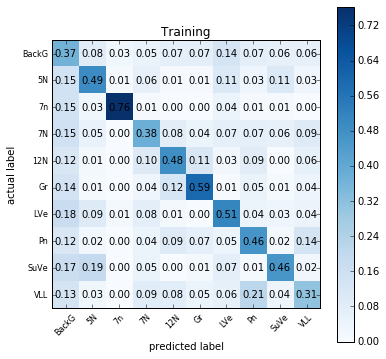

In [196]:
n_correct_train = 0;
for i in range(n_training):
    if train_predicted_labels[i] == training_y[i]:
        n_correct_train += 1;
print "Training accuracy: {}".format(1.0*n_correct_train / n_training);
cm_train = confusion_matrix(training_y, train_predicted_labels);
cm_train = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
fig = plt.figure(figsize=(6, 6));
plt.imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues);
plt.ylabel('actual label');
plt.xlabel('predicted label')
plt.title('Training');
plt.colorbar();
tick_marks = np.arange(len(labels));
plt.xticks(tick_marks, labels, rotation=45, fontsize=8);
plt.yticks(tick_marks, labels, fontsize=8);

ax = fig.add_subplot(111);
for x in xrange(len(labels)):
    for y in xrange(len(labels)):
        ax.annotate(
            "%.2f" % cm_train[x][y], 
            xy=(y, x), 
            horizontalalignment='center',
            verticalalignment='center');